In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import json, hashlib






In [2]:
"""General Functions"""

from ising import run_multi_core, set_input
from glob import glob

def dict_to_string(dict):
    t_name=""
    for key, val in dict.items():
        t_name+=str(key)+":"+str(val)+" "
    return t_name


def run(params = {}):
    inp = set_input("")
    for key,value in params.items():
        inp[key]=value


    inpstring = dict_to_string(inp)

    run_multi_core(inp)




OSError: dlopen(./ising_lattice_lib.so, 0x0006): tried: './ising_lattice_lib.so' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/System/Volumes/Preboot/Cryptexes/OS./ising_lattice_lib.so' (no such file), '/Users/gfitez/anaconda3/lib/python3.10/lib-dynload/../.././ising_lattice_lib.so' (no such file), '/Users/gfitez/anaconda3/bin/../lib/./ising_lattice_lib.so' (no such file), '/usr/lib/./ising_lattice_lib.so' (no such file, not in dyld cache), './ising_lattice_lib.so' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/Users/gfitez/Documents/382L/ising/ising_lattice_lib.so' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/gfitez/Documents/382L/ising/ising_lattice_lib.so' (no such file), '/Users/gfitez/Documents/382L/ising/ising_lattice_lib.so' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64'))

[ 2.21771622e+00  4.98503227e-05 -1.00003443e+00] [ 2.23678783e+00  3.92534955e-05 -1.00000144e+00]


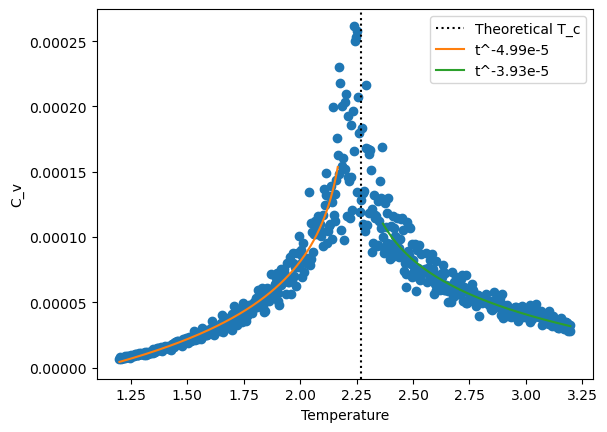

In [4]:
"""Calculate alpha"""
Tc=2.269

#SC,EM = getRun({"t_step":0.01, "flip_perc":0.1, "N":100, "t_min":1.2, "t_max":3.2, "n_burnin":60000, "n_steps":100000, "t_top":4, "B_top":1, "use_gaussian":True})
#run({"t_step":0.01, "flip_perc":0.1, "N":100, "t_min":1.2, "t_max":3.2, "n_burnin":60000, "n_steps":100000, "t_top":4, "B_top":1, "use_gaussian":False})

SC = pd.read_csv("data/1.20T3.20_SC_v0.csv", skiprows=[0,1,2])
EM = pd.read_csv("data/1.20T3.20_EM_v0.csv", skiprows=[0,1,2])

def spike(x,Tc,a,c):
    return np.abs((x-Tc)/Tc)**-a+c

T=EM["Temp"]
cv=1/T**2*(EM["E_std"]**2)#why is T squared? because beta=1/(kb*T)

plt.plot(T,cv,"o")
#plt.errorbar(T,cv,)
plt.axvline(2.269,color="k",linestyle=":", label="Theoretical T_c")


leftTop = np.where(T > Tc-0.1)[0][0]
rightBottom = np.where(T<Tc+0.1)[0][-1]

leftT=T[0:leftTop]
rightT=T[rightBottom:]

lpopt, lpcov = curve_fit(spike,leftT,cv[0:leftTop], p0=(2.26,0,0))
rpopt, rpcov = curve_fit(spike,rightT,cv[rightBottom:], p0=(2.26,0,0))

plt.plot(leftT,spike(leftT,*lpopt), label=f"t^-{round(lpopt[1]*1e5,2)}e-5")
plt.plot(rightT,spike(rightT,*rpopt), label=f"t^-{round(rpopt[1]*1e5,2)}e-5")


print(lpopt,rpopt)

plt.xlabel("Temperature")
plt.ylabel("C_v")
plt.legend()
#popt,pcov = curve_fit(spike,T,cv, p0=(2.26,0,0))
#plt.plot(T,spike(T,*popt))
#print(popt)


[2.24136385 0.13355016 1.21727841]
0.06840131211076694


/var/folders/rl/cpjcq0556r36l75xt982r2kh0000gn/T/ipykernel_1050/1404201833.py:33: RuntimeWarning: invalid value encountered in power
  return (1-np.sinh(2/(T*Tc+Tc))**-4)**0.125


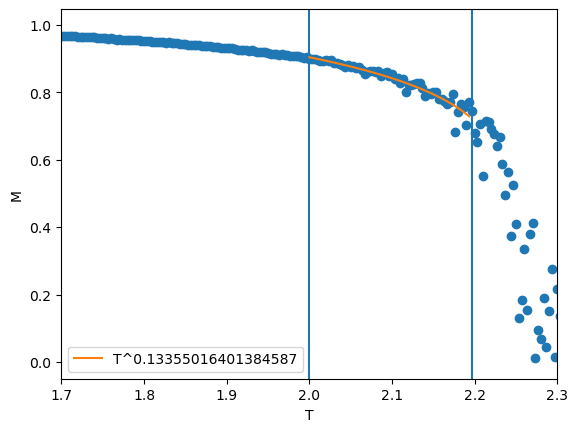

In [40]:
"""Calculate beta"""

#SC,EM = getRun({"t_step":0.01, "flip_perc":0.05, "N":40, "t_min":1.6, "t_max":2.3, "n_burnin":75000, "n_steps":100000, "b_top":10, "t_top":20, "use_gaussian":False})

M=abs(EM["M_mean"])
T=EM["Temp"]
plt.plot(T,M,"o")

def sloop(t,Tc,beta,b):
    return b*np.abs((t-Tc)/Tc)**beta
#def line(x,m,b):
#    return x*m+b

iMin = np.where(T > 2)[0][0]
iMax = np.where(T<2.2)[0][-1]

plt.axvline(T[iMin])
plt.axvline(T[iMax])

popt,pcov = curve_fit(sloop,T[iMin:iMax],M[iMin:iMax],p0=(2.265,1/8,1), maxfev=5000, bounds=([2,1/16,-10],[2.5,1/4,10]))
#popt,pcov = curve_fit(line,T[iMin:iMax],M[iMin:iMax])
print(popt)

plt.plot(T[iMin:iMax],sloop(T[iMin:iMax],*popt),label=f"T^{popt[1]}")
plt.xlabel("T")
plt.ylabel("M")
plt.legend()
plt.xlim(1.7,2.3)
#plt.yscale("log")
#plt.xscale("log")

def analyticalM(T):
    return (1-np.sinh(2/(T*Tc+Tc))**-4)**0.125

plt.plot(np.linspace(np.min(T),0,100),analyticalM(np.linspace(np.min(T),0,100)))


print((popt[1]-0.125)/0.125)

[ 2.21771622e+00  4.98503227e-05 -1.00003443e+00] [ 2.23678783e+00  3.92534955e-05 -1.00000144e+00]


(2.0, 3.0)

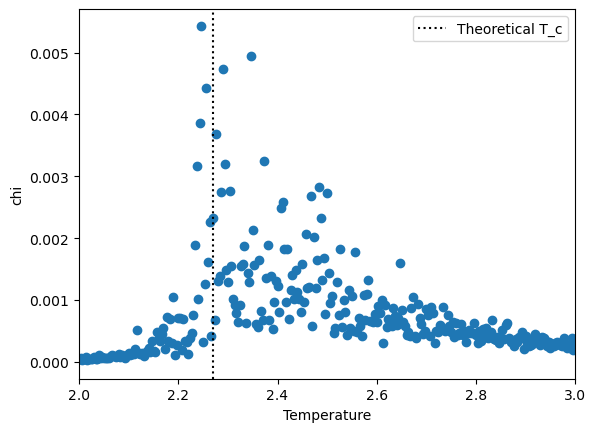

In [41]:
"""Calculate gamma"""
#use the other way to get gamma


#SC,EM = getRun({"t_step":0.05, "flip_perc":0.2, "N":30, "t_min":1.2, "t_max":3.2, "n_burnin":25000, "n_steps":50000, "t_top":4, "use_gaussian":False})

def chiSpike(x,Tc,a,c,d):
    #Tc=2.269
    return c*np.abs((x-Tc)/Tc)**-a+d

T=EM["Temp"]
M=EM["M_mean"]

chi=1/T*EM["M_std"]**2

plt.plot(T,chi,"o")
plt.axvline(2.269,color="k",linestyle=":", label="Theoretical T_c")


leftTop = np.where(T > Tc+0.2)[0][0]
rightBottom = np.where(T<Tc)[0][-1]

leftT=T[0:leftTop]
rightT=T[rightBottom:]



#lpopt, lpcov = curve_fit(chiSpike,leftT,chi[0:leftTop], p0=(2.26,7/4,0,0), maxfev=50000)
#rpopt, rpcov = curve_fit(chiSpike,rightT,chi[rightBottom:], p0=(2.26,7/4,0,0), maxfev=50000)

#plt.plot(leftT[0:leftTop],chiSpike(leftT[0:leftTop],*lpopt), label=f"t^-{round(lpopt[1],5)}")
#plt.plot(rightT,chiSpike(rightT,*rpopt), label=f"t^-{round(rpopt[1],5)}")
print(lpopt,rpopt)

plt.xlabel("Temperature")
plt.ylabel("chi")
plt.legend()
plt.xlim(2,3)


In [42]:
"""Calculate delta (I realized we actually don't have to do this)"""

Bs=np.linspace(0,2,30)
EMs=[]
for B in Bs:
    SC,EM = getRun({"t_step":0.1, "flip_perc":0.2, "N":30, "t_min":1.2, "t_max":3.2, "n_burnin":25000, "n_steps":50000, "t_top":4, "B":B ,"use_gaussian":False})
    EMs.append(EM)

for EM,B in zip(EMs,Bs):
    M=EM["M_mean"]
    plt.plot([B]*len(M),M,"o")

plt.xlabel("B")
plt.ylabel("M")



NameError: name 'getRun' is not defined

1.2
1.2033333333333334
1.2066666666666668
1.2100000000000002
1.2133333333333336
1.216666666666667
1.2200000000000004
1.2233333333333338
1.2266666666666672
1.2300000000000006
1.233333333333334
1.2366666666666677
1.2400000000000009
1.2433333333333343
1.2466666666666677
1.250000000000001
1.2533333333333343
1.256666666666668
1.2600000000000011
1.2633333333333348
1.2666666666666682
1.2700000000000016
1.273333333333335
1.2766666666666684
1.2800000000000018
1.2833333333333352
1.2866666666666686
1.290000000000002
1.2933333333333354
1.2966666666666689
1.3000000000000025
1.3033333333333357
1.306666666666669
1.3100000000000025
1.313333333333336
1.316666666666669
1.3200000000000027
1.323333333333336
1.3266666666666695
1.330000000000003
1.3333333333333364
1.3366666666666698
1.3400000000000032
1.3433333333333366
1.34666666666667
1.3500000000000034
1.3533333333333368
1.3566666666666702
1.3600000000000037
1.363333333333337
1.3666666666666705
1.370000000000004
1.3733333333333373
1.3766666666666707
1.38

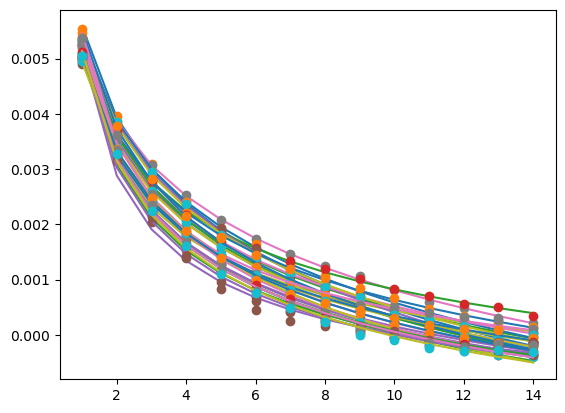

0.25760212159861856


In [43]:
"""Calculate eta"""
#SC,EM = getRun({"t_step":0.01, "flip_perc":0.05, "N":100, "t_min":2.3, "t_max":2.7, "n_burnin":25000, "n_steps":50000, "b_top":10, "t_top":20, "use_gaussian":False})

def correlationFalloff(x,eta,c,a):
    return a*np.abs(x)**(-eta)+c


temps=[]
x=0
count=0
for i in range(SC.shape[0]):
    row = SC.iloc[i]
    print(row[0])
    temps.append(row[0])

    if temps[-1] >2.3 and temps[-1]<2.4:

        correlations=row[1:15]
        xVals=np.arange(1,len(correlations)+1)

        popt,pcov = curve_fit(correlationFalloff, xVals, correlations, maxfev=5000)

        plt.plot(xVals, correlationFalloff(xVals, *popt))
        plt.plot(xVals, correlations,"o")
        print(popt)
        x+=popt[0]
        count+=1

    #xis.append(popt[0])
plt.show()
print(x/count)



[2.87490912e+00 1.57043800e-04 5.05716967e-03]
[4.06773989e+00 6.34804939e-04 5.80807704e-03]
[3.08852742e+00 5.79767365e-04 5.95900170e-03]
[3.11737126e+00 1.47949429e-04 6.91042816e-03]
[3.18438741e+00 5.82769439e-04 5.46718521e-03]
[2.98621796e+00 9.03539837e-04 5.88475961e-03]
[3.19161842e+00 6.81764941e-04 5.36926970e-03]
[3.45492184e+00 9.29602043e-05 6.42534943e-03]
[ 3.88146505e+00 -3.37688095e-04  7.16694654e-03]
[3.47252695e+00 1.43988723e-04 7.07350458e-03]
[3.26883761e+00 2.58791117e-04 6.21389495e-03]
[ 3.24752933e+00 -3.17017136e-04  6.99224576e-03]
[3.31997678e+00 6.54066981e-04 6.14005221e-03]
[2.53520639e+00 3.40596644e-04 6.81942179e-03]
[3.48477796e+00 3.18140513e-04 6.58582007e-03]
[2.49684486e+00 8.81247927e-04 6.44235455e-03]
[3.43121585e+00 2.62700684e-04 6.55898240e-03]
[2.73320317e+00 4.84107072e-04 6.86071843e-03]
[3.43240625e+00 1.86441726e-04 6.79495920e-03]
[2.81571576e+00 5.96407666e-04 6.52637493e-03]
[ 3.43979321e+00 -6.06058055e-05  6.94987104e-03]
[3.0

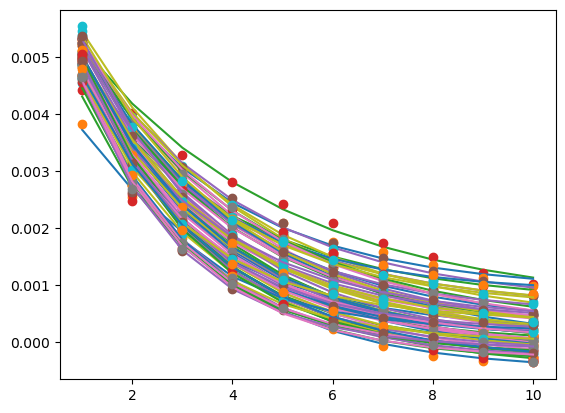

[  2.6          0.96211527   3.4227794  -10.51681118]


/Users/gfitez/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


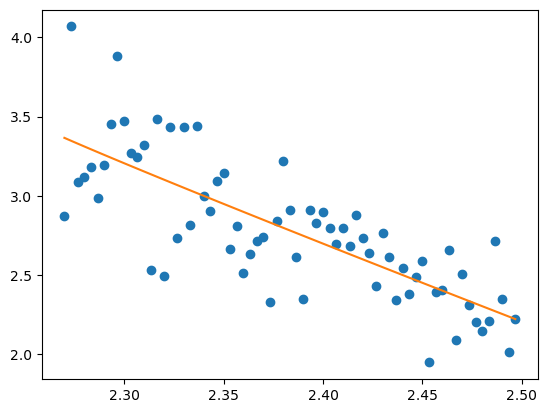

In [46]:
"""Calculate nu"""
#SC,EM = getRun({"t_step":0.01, "flip_perc":0.05, "N":100, "t_min":2.3, "t_max":2.7, "n_burnin":25000, "n_steps":50000, "b_top":10, "t_top":20, "use_gaussian":False})


correlations=[]
temps=[]

def correlationFalloff(d,xi,c,a):
    return a*np.exp(-d/xi)+c


xis=[]
for i in range(SC.shape[0]):
    row = SC.iloc[i]
    temp=row[0]

    if temp>Tc and temp<2.5:
        temps.append(temp)

        correlations=row[1:11]
        xVals=np.arange(1,len(correlations)+1)

        popt,pcov = curve_fit(correlationFalloff, xVals, correlations, maxfev=20000)
        print(popt)
        plt.plot(xVals, correlationFalloff(xVals, *popt))
        plt.plot(xVals, correlations,"o")

        xis.append(popt[0])
plt.show()


plt.plot(temps,xis,"o")

def correlationVTemp(t,Tc,nu,c,a):
    Tc=2.26
    return a*abs((t-Tc)/Tc)**nu+c

popt,pcov = curve_fit(correlationVTemp, temps, xis, maxfev=50000, p0=(2.6,1,0,1))


plt.plot(temps,correlationVTemp(np.array(temps), *popt))
print(popt)

